<a href="https://colab.research.google.com/github/robgon-art/ml-tabify/blob/main/tab2midi.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# tab2midi
Based on https://briancaffey.github.io/2018/04/26/generating-music-from-guitar-tabs-with-python.html/

In [1]:
!pip install --upgrade music21

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.8/22.8 MB 64.1 MB/s eta 0:00:00
  Attempting uninstall: music21
    Found existing installation: music21 8.1.0
    Uninstalling music21-8.1.0:
      Successfully uninstalled music21-8.1.0


In [2]:
# enables music21 to render images of musical notes
print('installing lilypond...')
!apt-get install lilypond > /dev/null

# converts midi files to wav files into order to play them
print('installing fluidsynth...')
!apt-get install fluidsynth > /dev/null
!cp /usr/share/sounds/sf2/FluidR3_GM.sf2 ./font.sf2

print('done!')

installing lilypond...
Extracting templates from packages: 100%
installing fluidsynth...
done!


In [3]:
import music21
from IPython.display import Image, Audio, HTML
!fluidsynth --version
!lilypond --version
print("music21 version:", music21.__version__)

def show(music):
  display(Image(str(music.write('lily.png'))))

def play(filename):
  # filename = music.write('mid')
  !fluidsynth -ni font.sf2 $filename -F $filename\.wav -r 16000 > /dev/null
  display(Audio(str(filename) + '.wav'))

def show_play(midi_file):
  mf = music21.midi.MidiFile()
  mf.open(midi_file)
  mf.read()
  mf.close()
  s = music21.midi.translate.midiFileToStream(mf)
  show(s)
  play(midi_file)

FluidSynth runtime version 2.1.1
Copyright (C) 2000-2020 Peter Hanappe and others.
Distributed under the LGPL license.
SoundFont(R) is a registered trademark of E-mu Systems, Inc.

FluidSynth executable version 2.1.1
Sample type=double
GNU LilyPond 2.20.0

Copyright (c) 1996--2015 by
  Han-Wen Nienhuys <hanwen@xs4all.nl>
  Jan Nieuwenhuizen <janneke@gnu.org>
  and others.

This program is free software.  It is covered by the GNU General Public
License and you are welcome to change it and/or distribute copies of it
under certain conditions.  Invoke as `lilypond --warranty' for more
information.

music21 version: 8.3.0


based on https://briancaffey.github.io/2018/04/26/generating-music-from-guitar-tabs-with-python.html/

In [4]:
!pip install midiutil

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 11.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for midiutil: filename=MIDIUtil-1.2.1-py3-none-any.whl size=54567 sha256=ead0f14da63e1884d79747b300a5cf76187c815d9a956c6bae898731f8992ee5
  Stored in directory: /root/.cache/pip/wheels/af/43/4a/00b5e4f2fe5e2cd6e92b461995a3a97a2cebb30ab5783501b0
Successfully built midiutil


In [5]:
from midiutil import MIDIFile
import sys
import re

def tab2mid(input_file, output_file):

  string_notes = ["e", "B", "G", "D", "A", "E"]

  guitar_strings = {
    'E':{'note_val':52, 'track_num':0},
    'A':{'note_val':57, 'track_num':1},
    'D':{'note_val':62, 'track_num':2},
    'G':{'note_val':67, 'track_num':3},
    'B':{'note_val':71, 'track_num':4},
    'e':{'note_val':76, 'track_num':5},
  }

  # read the tab file
  with open(input_file) as f:
    contents = f.read()

  contents = contents.replace("h", "-")
  contents = contents.replace("p", "-")
  contents = contents.replace("/", "-")
  contents = contents.replace("*", "-")
  # contents = contents.upper()
  bar_group = re.findall(r"(?:[e,E,B,G,D,A,-]+\|[0-9-h|]+\n){6}",contents)

  track    = 0
  channel  = 0
  time     = 0     # In beats
  duration = 1     # In beats
  tempo    = 140   # In BPM
  volume   = 100   # 0-127, as per the MIDI standard
  program  = 0    # Zero based, 30=Distortion guitar, https://www.midi.org/specifications-old/item/gm-level-1-sound-set

  MyMIDI = MIDIFile(1)  # One track, defaults to format 1 (tempo track is created
                        # automatically)
  MyMIDI.addProgramChange(track, channel, time, program)
  MyMIDI.addTempo(track, time, tempo*4)

  interval = len(bar_group[0].split("\n")) - 1

  for b in bar_group:
    strings = b.split("\n")
    strings = [x for x in strings if x != '']
    e_count = 0
    for i, s in enumerate(strings):
      current_string = strings[i][0]
      if current_string not in guitar_strings.keys():
        current_string = string_notes[i]
      if current_string == "E":
        e_count += 1
      if e_count == 2:
        current_string == "e"

      s = s[1:]
      s = s.replace('|', '')
      s = list(s)

      for i, pitch in enumerate(s):
        volume = 127
        if pitch == "\n":
          break
        if pitch == "-":
          volume = 0
          pitch = 50
        # print("adding note")
        pitch = int(pitch) + guitar_strings[current_string]['note_val']
        MyMIDI.addNote(track, channel, pitch, time + i, duration, volume)

    time += interval*8

  with open(output_file, "wb") as output:
    MyMIDI.writeFile(output)

In [12]:
%%writefile tab1.txt
e|-----------------|-----------------|-----------------|-----------------|
B|-----7-8-------8-|-8-8-7-7---------|-5-5-7-7-------8-|-8-8-7-7-5--5-5--|
G|---7-------7-7---|---------7--7-7--|-----------7-7---|-----------------|
D|-5---------------|-----------------|-----------------|-----------------|
A|-----------------|-----------------|-----------------|-----------------|
E|-----------------|-----------------|-----------------|-----------------|

Writing tab1.txt


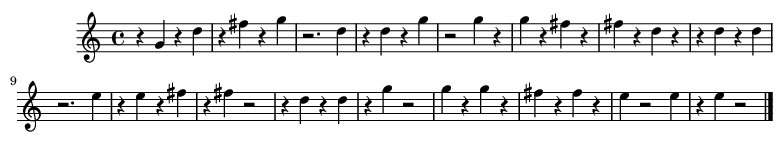

In [13]:
tab2mid("tab1.txt", "tab1.mid")
show_play("tab1.mid")